In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import re

import time
from tqdm import tqdm
import datetime as dt
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns", 500)

In [3]:
# custom imports
from load_data import load_data

# Loading data from json and creating DataFrame

In [8]:
read_in = True
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene']
dates = ['08-{:02d}'.format(i) for i in range(2,13)]
if read_in:
    parties = parties
    dates = dates
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')

  0%|          | 0/11 [00:00<?, ?it/s]

Loading: ['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09', '08-10', '08-11', '08-12']


  0%|          | 0/11 [00:00<?, ?it/s]

AfD loaded


  0%|          | 0/11 [00:00<?, ?it/s]

SPD loaded


  0%|          | 0/11 [00:00<?, ?it/s]

CDU loaded


  0%|          | 0/11 [00:00<?, ?it/s]

CSU loaded


  0%|          | 0/11 [00:00<?, ?it/s]

FDP loaded


  0%|          | 0/11 [00:00<?, ?it/s]

LINKE loaded


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Gruene loaded
Done


In [9]:
for party in parties:
    print(party, data[party].shape)

AfD (210580, 3)
SPD (50007, 3)
CDU (57718, 3)
CSU (40215, 3)
FDP (21726, 3)
LINKE (40043, 3)
Gruene (30787, 3)


# Quick excursion: Time series of tweets per minute

Count all tweets per timeframe and plot the tweetcount against time

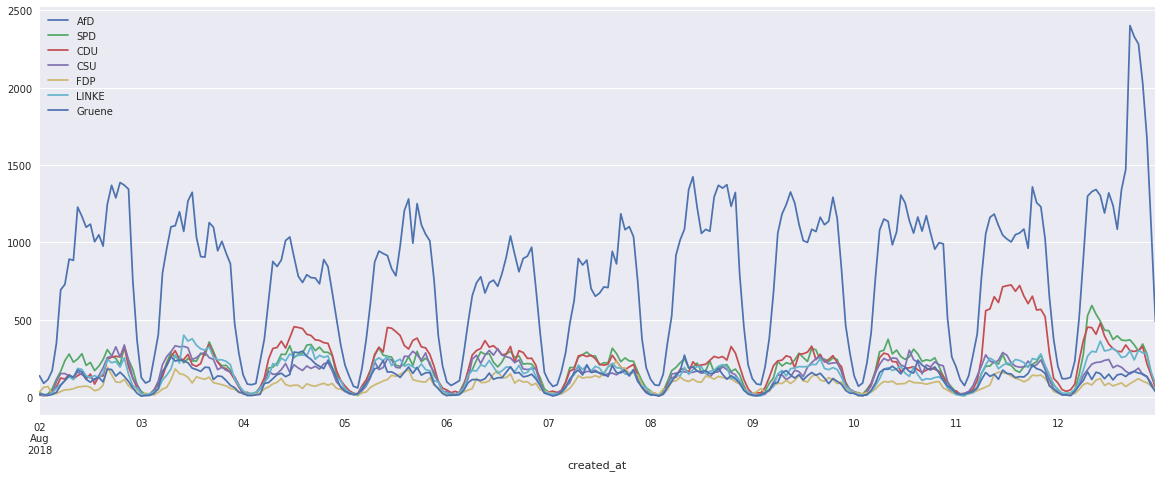

In [10]:
plt.figure(figsize=(20, 7.5))
ax = plt.axes()
for party in parties:
    data[party].loc[:, 'full_text'].resample('h').count().plot(ax=ax, label=party)
plt.legend()
# ax.grid(axis='both')
plt.show()

In [11]:
def plot_tweetcount(df_list):
    """
    Interactive plotly plot that shows exactly the same data as the previous plot but is interactive.
    """
    
#     define color for the respective party !sequence matters!
    party_colors = [['AfD', 'rgb(26, 124, 199)'],
                    ['SPD', 'rgb(210, 0, 0)'], 
                    ['CDU', 'rgb(0, 29, 77)'], 
                    ['CSU', 'rgb(26, 117, 255)'], 
                    ['LINKE', 'rgb(204, 0, 102)'], 
                    ['FDP', 'rgb(255, 204, 0)'], 
                    ['Gruene', 'rgb(0, 204, 0)']]
    
    traces = []

   
    for party, color in party_colors:
#         define the number of tweets per hour
        df = df_list[party]
        tweetcount = pd.DataFrame(df.loc[:, 'full_text'].
                                  resample('h').
                                  count())
#     define the traces for the plotly plot
        trace = go.Scatter(y = tweetcount.loc[:, 'full_text'],
                           x = tweetcount.index,
                           line = {'color': color},
                           name = party)
        traces.append(trace)
        
    
    layout = go.Layout(title='Party tweet-count per hour',
                       yaxis = dict(title='Tweets per hour'),
                       xaxis = dict(title='Days'))
    
    hourly_tweetcount = go.Figure(data=traces, layout=layout)
    py.offline.iplot(hourly_tweetcount)

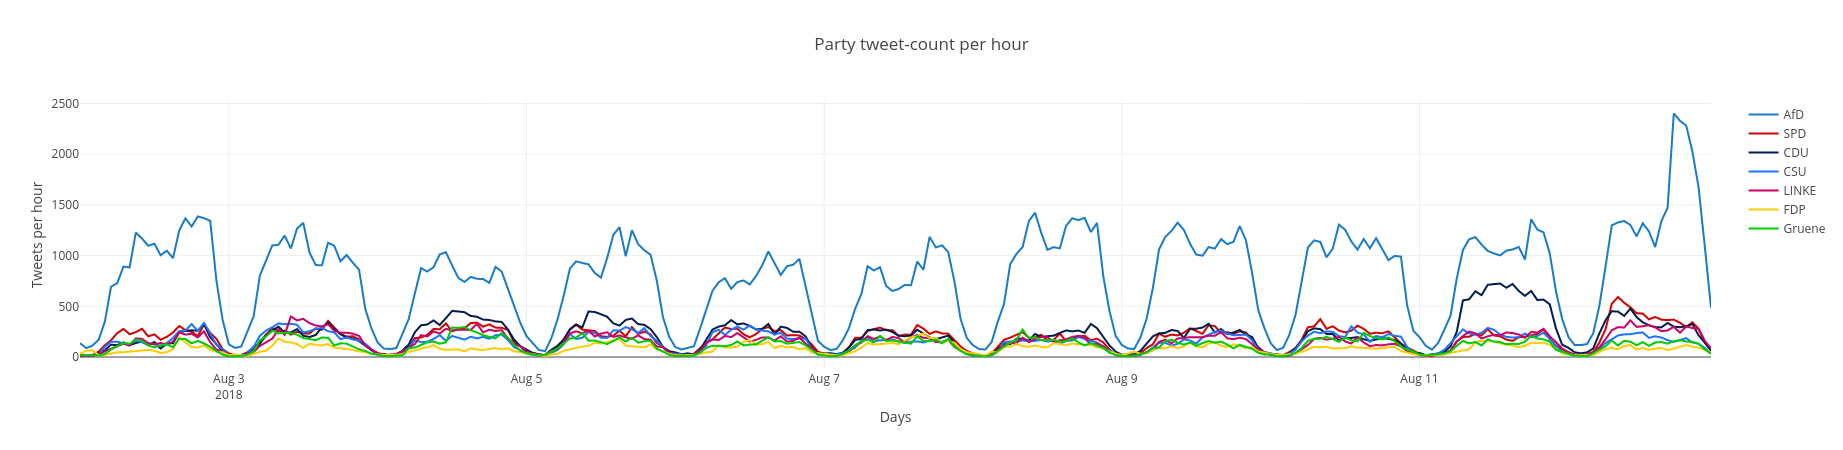

In [12]:
plot_tweetcount(data)

# Feature extraction and first clustering - 'quick and dirty'
1. Vectorization and standardization
2. Dimensionality reduction
3. Clustering

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [14]:
vectorizer = CountVectorizer() # transforms text data to sparse vector of numbers
scaler = StandardScaler(with_mean = False) # standardises the numbers -> values with mean 0 and std of 1
svd = TruncatedSVD(n_components = 2, 
                   random_state = 123) # dimensionality reduction; svd can handle sparse data, PCA can't

preprocessing_pipe = Pipeline(steps = [('vectorizer', vectorizer), 
                                       ('scaler', scaler), 
                                       ('svd', svd)])



kmeans_clsf = KMeans(n_clusters=3, # number of desired clusters
                     random_state=123, 
                     n_init = 10, # run algorithm 10 times independently with different random centroids to choose the final model as the one with lowest sse
                     init='random', 
                     max_iter=50, # max number of iterations per single run
                     tol=1e-04) # controls tolerance with regard to the changes in the within-cluster sse to declare convergence

In [15]:
def first_clustering(dict_of_df):
    X = {}
    y_km = {}
    text = {}
    centers = {}
    
    for party in parties:
        df = data[party]
        text[party] = (df.loc[:, 'full_text']).tolist()

        X[party] = preprocessing_pipe.fit_transform(text[party])

        y_km[party] = kmeans_clsf.fit_predict(X[party])
        centers[party] = kmeans_clsf.cluster_centers_
        
    return X, y_km, centers

In [16]:
X, y_km, centers = first_clustering(data)

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConvers

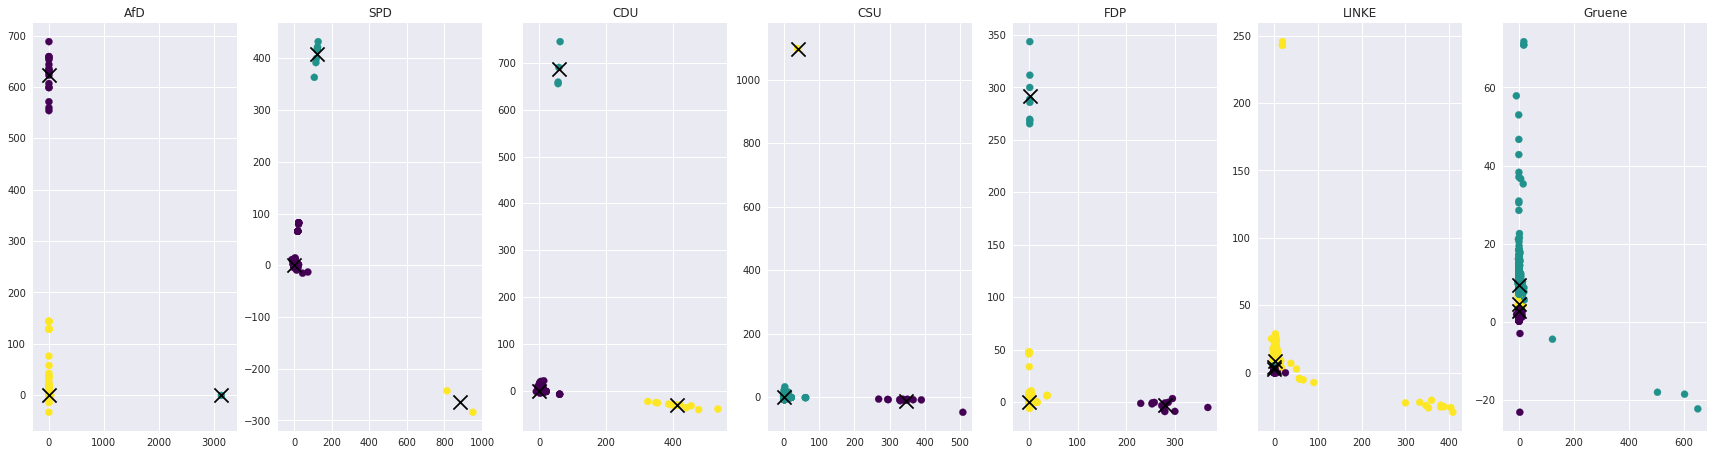

In [17]:
f, axarr = plt.subplots(1, 7, figsize=(30, 7.5))

for i, party in enumerate(parties):
    ax = axarr[i]
    
    ax.scatter(X[party][:, 0], X[party][:, 1], c=y_km[party], s=50, cmap='viridis')
    ax.set_title(party)

    center = centers[party]
    ax.scatter(center[:, 0], center[:, 1], c='black', s=200, marker='x');

# Extract hashtags and party mentions

In [18]:
# removes special characters from text
text_cleaner = lambda x: " ".join(re.findall(r"[A-Za-z0-9üäöÜÄÖß#@ ]*", x))

# extracts hashtags from full_text
tag_finder = lambda x: re.findall(r"#(\w+)", x)

# removes hashtags from full_text
tag_remover = lambda x: re.sub("#(\w+)", '', x)

# finds all parties mentioned in text
def party_finder(x):
    parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
    text = x.lower()
    out = []
    for party in parties:
        if party.lower() in text:
            out.append(party)
    return out

In [19]:
def text_processing(dict_of_DFs, parties):
    for party in parties:
        df = dict_of_DFs[party]
        df['tags'] = df['full_text'].apply(tag_finder)
        df['clean_text'] = df['full_text'].apply(text_cleaner).apply(tag_remover).astype('str')
        df['parties'] = df['clean_text'].map(party_finder)

In [20]:
text_processing(data, parties)

In [29]:
data['SPD'].head()

,created_at,id_str,full_text,tags,clean_text,parties
created_at,,,,,,
2018-08-02 00:00:05,2018-08-02 00:00:05,1024807007012904960,camaro hot rat rod 454 350 5 spd 4 spd - https://t.co/WMTPNfFH0v https://t.co/5eRhMtAhZG,[],camaro hot rat rod 454 350 5 spd 4 spd https t co WMTPNfFH0v https t co 5eRhMtAhZG,[SPD]
2018-08-02 00:00:14,2018-08-02 00:00:14,1024807045411889152,@BILD Für Sami A macht man Rundflüge. gute Migranten Flüchtlinge weißt man aus Demokratie versteht man hier nicht ☝️☝️#CSU #AfD #Bild #CSU #Bild #CSU #SPD #FDP #AFD #Bild #CSU #Bild #CSU #SPD #FDP #AFD #Bild,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD, Bild, CSU, Bild, CSU, SPD, FDP, AFD, Bild]",@BILD Für Sami A macht man Rundflüge gute Migranten Flüchtlinge weißt man aus Demokratie versteht man hier nicht,[]
2018-08-02 00:01:18,2018-08-02 00:01:18,1024807316527476736,"@RPHeier Auf jedenfall ist dies keine gute Richtung die sie hier der SPD geben will, weil im Gesamtbild sagt sie auch dann, halten wir uns lieber in Richtung CDU",[],@RPHeier Auf jedenfall ist dies keine gute Richtung die sie hier der SPD geben will weil im Gesamtbild sagt sie auch dann halten wir uns lieber in Richtung CDU,"[SPD, CDU]"
2018-08-02 00:03:11,2018-08-02 00:03:11,1024807787380072448,"RT @JessicaBiessman: Die Genossen der #SPD lehnen 55 Aufnahmeanträge von türkischstämmigen Bürgern ab, da sie eine #Unterwanderung fürchten…","[SPD, Unterwanderung]",RT @JessicaBiessman Die Genossen der lehnen 55 Aufnahmeanträge von türkischstämmigen Bürgern ab da sie eine fürchten,[]
2018-08-02 00:03:49,2018-08-02 00:03:49,1024807947367534592,"@satirianexe Meine Erfahrungen seitdem ich in der SPD bin, es herrscht so das Motto - Nix anfassen, was schwierig ist und wo man sich verbrennen kann. Ich vermisse den Mut visionäre Dinge mal anzugehen",[],@satirianexe Meine Erfahrungen seitdem ich in der SPD bin es herrscht so das Motto Nix anfassen was schwierig ist und wo man sich verbrennen kann Ich vermisse den Mut visionäre Dinge mal anzugehen,[SPD]
